# Red/Green Ratio Analysis for Clones b and c

This script analyzes and visualizes the red/green ratio (`BL2-A` / `BL1-A`) for CHO clones `b` and `c`. It includes steps to filter the data, calculate the ratio, generate visualizations, and perform statistical comparisons between the two clones over multiple time points.

## Key Features

1. **Filtering Data**:
   - Filters the dataset to include only clones `b` and `c`.

2. **Calculating Red/Green Ratio**:
   - Computes the ratio between red emission (`BL2-A`) and green emission (`BL1-A`) for each data point.

3. **Visualization**:
   - Generates violin plots to display the distribution of the red/green ratio across clones and time points.

4. **Statistical Analysis**:
   - Performs statistical tests (Student's t-test and Mann-Whitney U test) to compare clones `b` and `c` at each time point.

5. **Output**:
   - Displays the results of the statistical analysis in a summary table.

## Required Libraries

- `numpy`
- `pandas`
- `seaborn`
- `matplotlib`
- `scipy`

## How to Use

1. Ensure the input dataset includes the following columns:
   - `BL1-A`: Green emission data.
   - `BL2-A`: Red emission data.
   - `Clone`: Clone identifiers (`b` or `c`).
   - `Time`: Time points for the experiment.

2. Run the script to:
   - Filter and preprocess the data.
   - Generate visualizations.
   - Compute statistical tests.

3. Review the generated violin plots and statistical results to assess differences between clones `b` and `c`.

## Outputs

- **Violin Plots**:
  - Visualizations of the red/green ratio distribution by clone and time.
- **Statistical Results**:
  - Summary table including:
    - T-statistic and p-value from Student's t-test.
    - U-statistic and p-value from Mann-Whitney U test.


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from matplotlib.path import Path

Data preview:


,Time,FSC-A,SSC-A,BL1-A,BL2-A,FSC-H,SSC-H,File_Name,Folder,Clone,Replicate,Sample_Type
0,1,814.0,4109.0,7.0,7.0,1235.0,4462.0,19ago2024_JC1_EBR_Controles_CCCP_b1_JC1.fcs,19ago2024_T1,CCCP,1.0,Control
1,1,347.0,4944.0,46.0,1553.0,998.0,4913.0,19ago2024_JC1_EBR_Controles_CCCP_b1_JC1.fcs,19ago2024_T1,CCCP,1.0,Control
2,1,407.0,4296.0,8.0,-38.0,1248.0,4279.0,19ago2024_JC1_EBR_Controles_CCCP_b1_JC1.fcs,19ago2024_T1,CCCP,1.0,Control
3,1,242.0,4867.0,88.0,2011.0,1565.0,4641.0,19ago2024_JC1_EBR_Controles_CCCP_b1_JC1.fcs,19ago2024_T1,CCCP,1.0,Control
4,1,264287.0,277235.0,2394.0,1152.0,183252.0,188020.0,19ago2024_JC1_EBR_Controles_CCCP_b1_JC1.fcs,19ago2024_T1,CCCP,1.0,Control


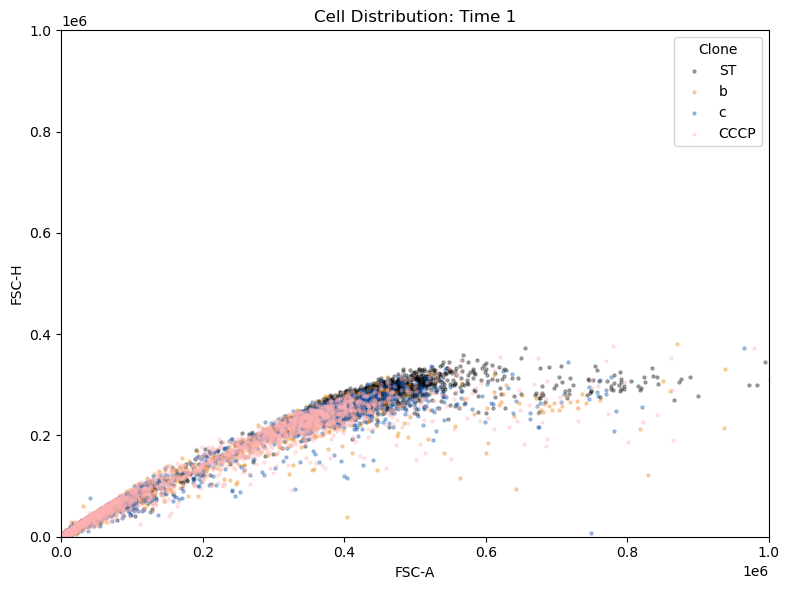

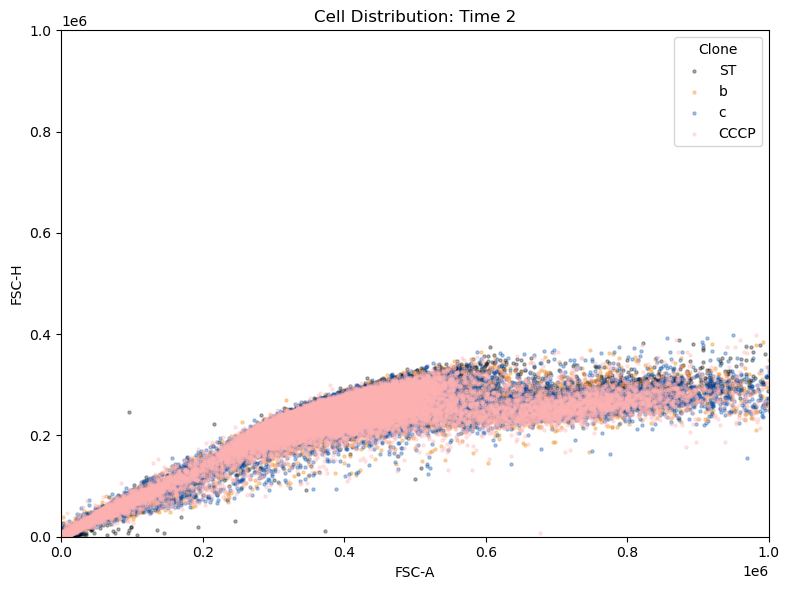

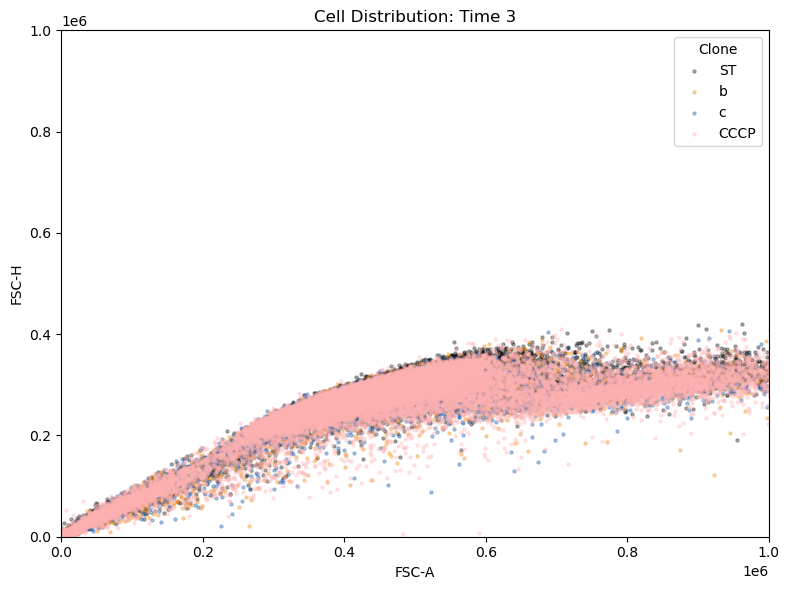

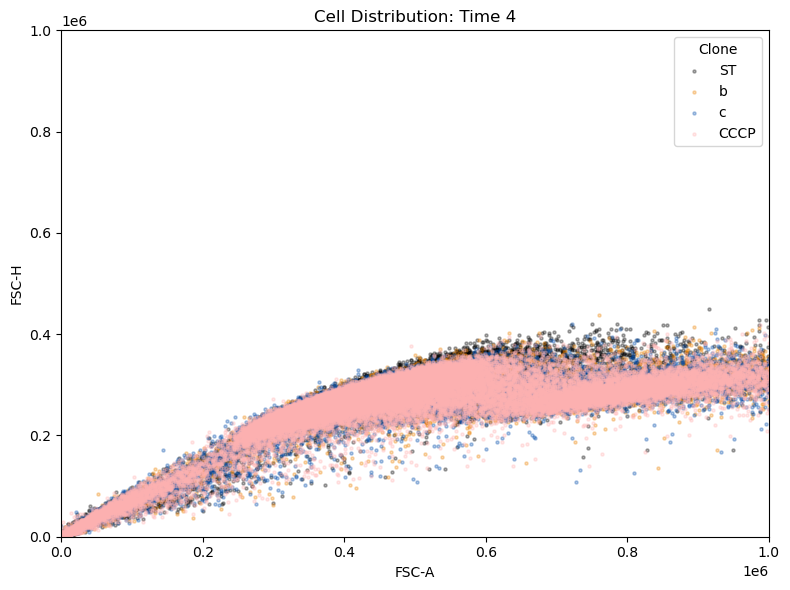

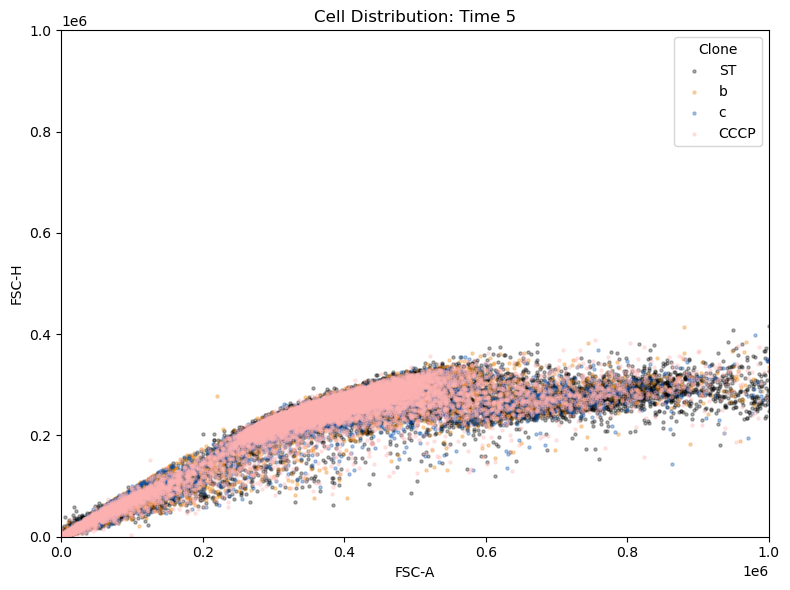

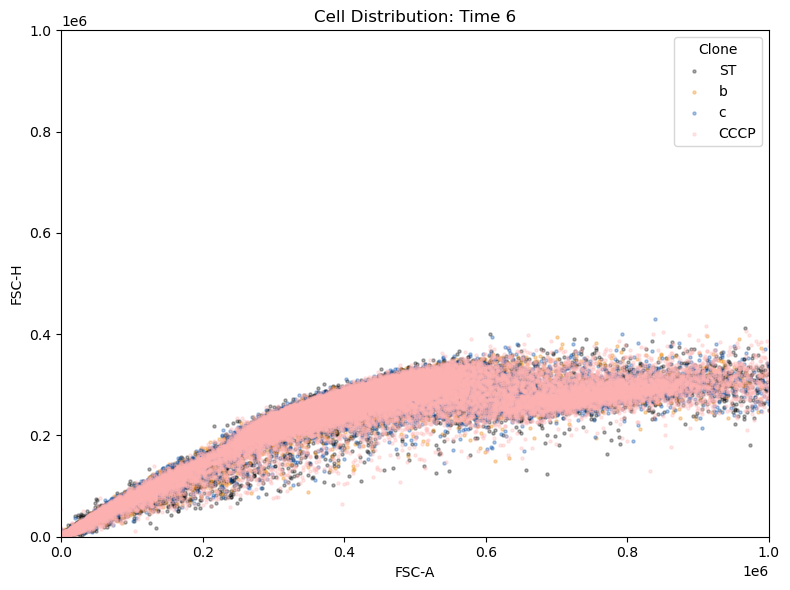

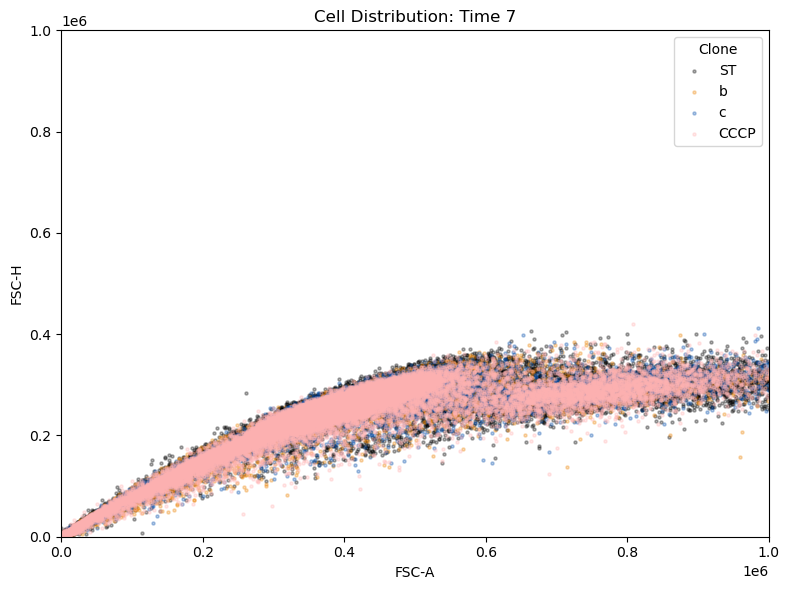

In [3]:
# Define the input CSV file path
input_file = "data/processed_data.csv"

# Read the CSV file into a DataFrame
data = pd.read_csv(input_file)

# Display the first few rows of the data for verification
print("Data preview:")
display(data.head())

# Subsample the data: Randomly select 10% of rows from each group
data_sampled = data.groupby(['Time', 'Clone']).sample(frac=0.1, random_state=1)

# Define a color map for each group
color_map = {
    'ST': '#000000',    # Black for ST
    'b': '#EC8305',     # Orange for clone b
    'c': '#024CAA',     # Blue for clone c
    'CCCP': '#FFB3B3'   # Soft red for CCCP controls
}

# Get unique time points
unique_times = data_sampled['Time'].unique()

# Generate scatter plots for each time point
for time in unique_times:
    # Filter data for the current time
    data_time = data_sampled[data_sampled['Time'] == time]

    # Configure the figure
    plt.figure(figsize=(8, 6))
    plt.title(f'Cell Distribution: Time {time}')
    plt.xlabel('FSC-A')
    plt.ylabel('FSC-H')
    plt.xlim(0, 1_000_000)  # Adjusted for typical flow cytometry data
    plt.ylim(0, 1_000_000)

    # Plot each group (Clone) with its designated color
    for clone, color in color_map.items():
        data_filtered = data_time[data_time['Clone'] == clone]
        plt.scatter(
            data_filtered['FSC-A'], 
            data_filtered['FSC-H'], 
            color=color, 
            s=5, 
            alpha=0.3, 
            label=clone
        )

    # Add legend and finalize the plot
    plt.legend(title="Clone")
    plt.tight_layout()
    plt.show()


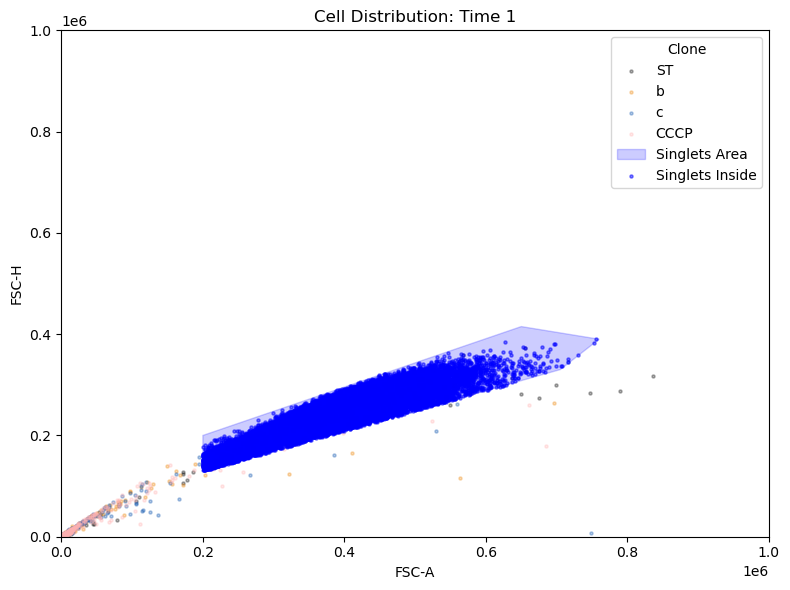

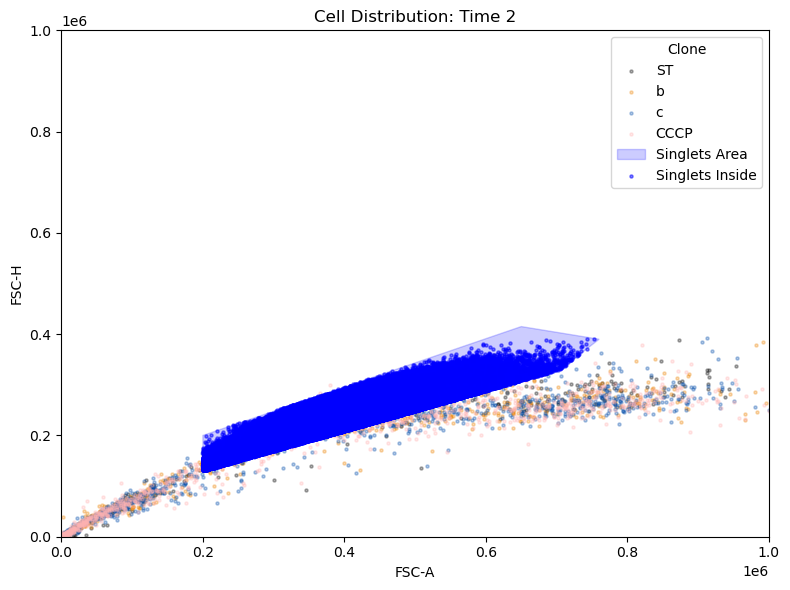

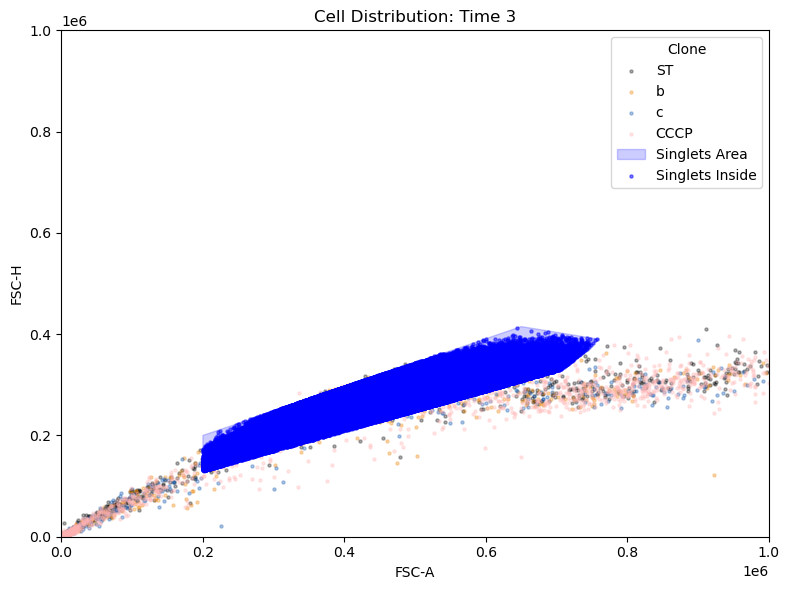

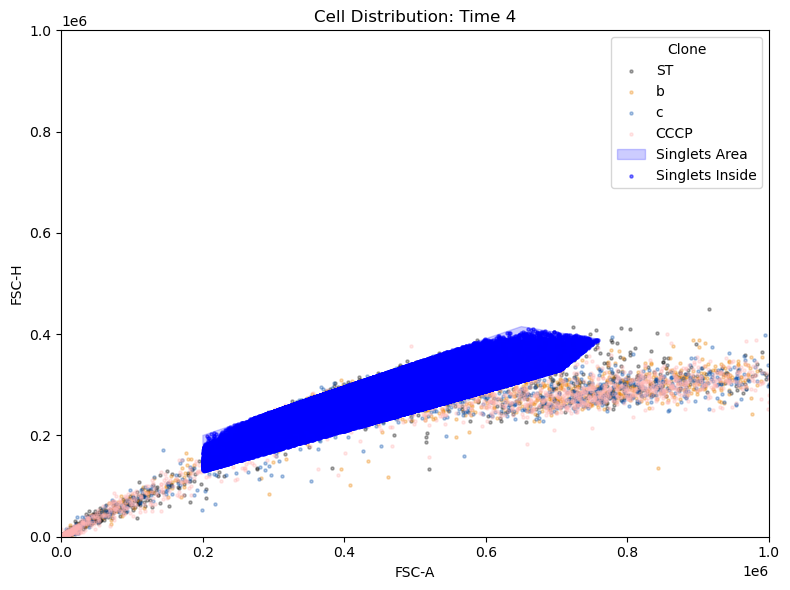

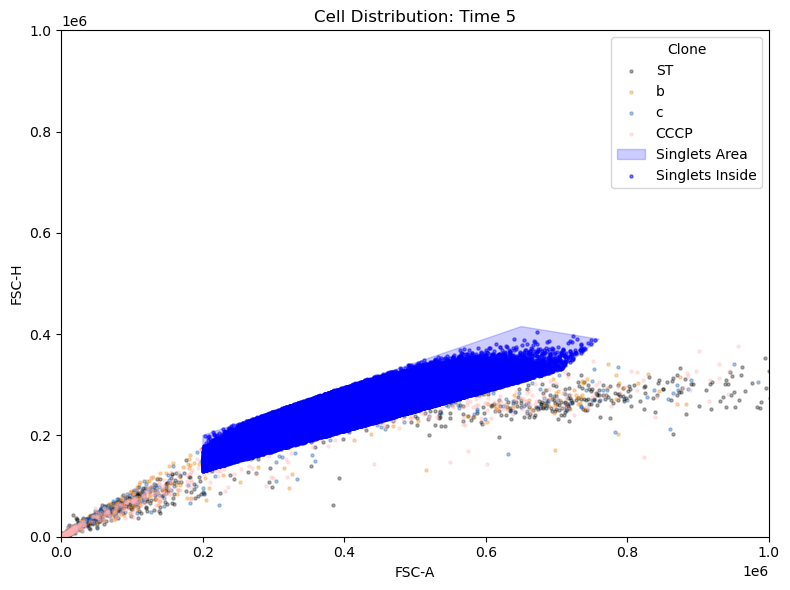

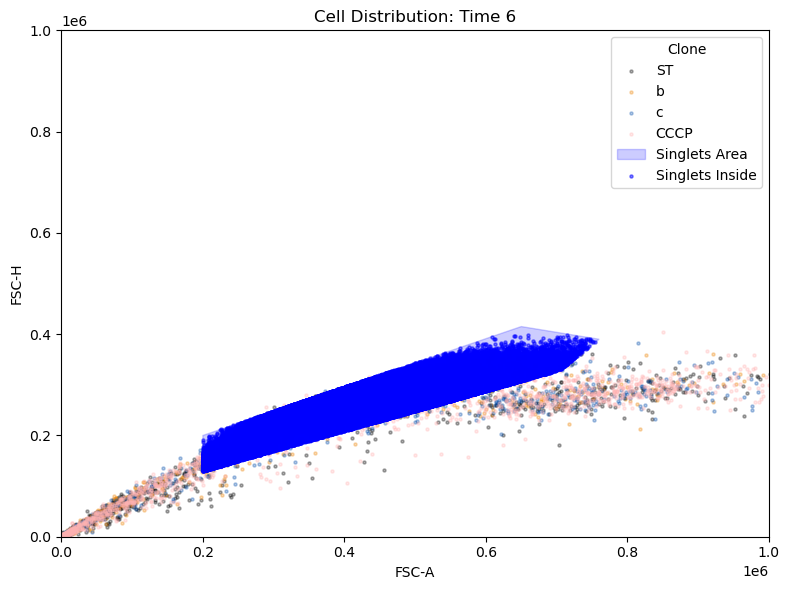

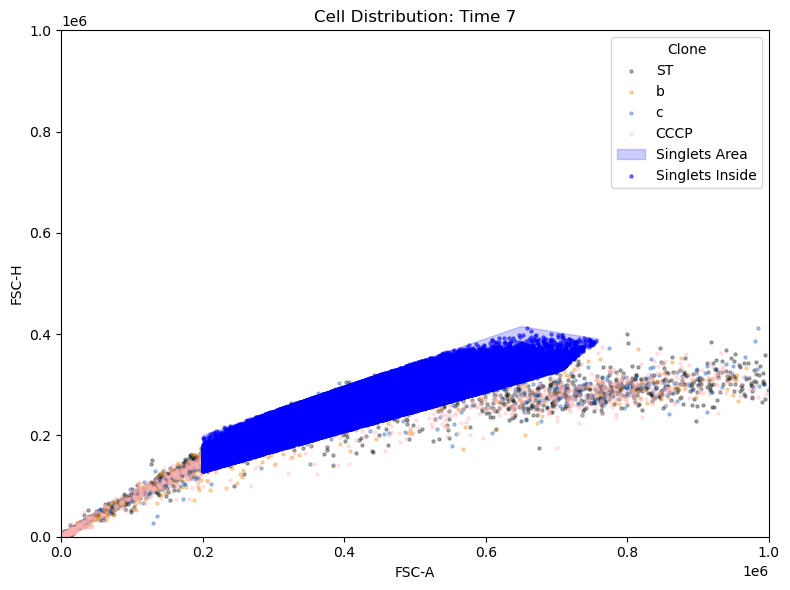

In [6]:
# Define the polygon for singlets
singlets_polygon_vertices = np.array([
    [200000, 200000], [200000, 130000], [705000, 330000], 
    [760000, 390000], [650000, 415000]
])
singlets_polygon_path = Path(singlets_polygon_vertices)

# Define colors for each group
color_map = {
    'ST': '#000000',    # Black for ST
    'b': '#EC8305',     # Orange for clone b
    'c': '#024CAA',     # Blue for clone c
    'CCCP': '#FFB3B3'   # Soft red for CCCP controls
}

# 1. **Filter data within the singlets polygon**
# Create a new DataFrame called `singlets_all` containing only data inside the polygon for all time points.
inside_singlets_polygon = data[['FSC-A', 'FSC-H']].apply(
    lambda point: singlets_polygon_path.contains_point((point['FSC-A'], point['FSC-H'])), axis=1
)
singlets_all = data.loc[inside_singlets_polygon].copy()

# 2. **Subsample 1% of the data in each group for quick visualization**
# Filter subsampled data by 'Time' and 'Clone'
data_sampled = data.groupby(['Time', 'Clone']).sample(frac=0.01, random_state=1)

# 3. **Visualize by Time with the singlets polygon**
# Get unique values of 'Time'
unique_times = data_sampled['Time'].unique()

# Create scatter plots for each time point with the singlets polygon
for time in unique_times:
    # Filter subsampled data and singlets data for the current time point
    data_time = data_sampled[data_sampled['Time'] == time]
    singlets_time = singlets_all[singlets_all['Time'] == time]

    # Configure the figure for the current time point
    plt.figure(figsize=(8, 6))
    plt.title(f'Cell Distribution: Time {time}')
    plt.xlabel('FSC-A')
    plt.ylabel('FSC-H')
    plt.xlim(0, 1_000_000)
    plt.ylim(0, 1_000_000)

    # Plot each group (Clone) for the current time point
    for clone, color in color_map.items():
        data_filtered = data_time[data_time['Clone'] == clone]
        plt.scatter(data_filtered['FSC-A'], data_filtered['FSC-H'], color=color, s=5, alpha=0.3, label=clone)

    # Draw the singlets polygon
    plt.fill(*zip(*singlets_polygon_vertices), color='blue', alpha=0.2, label='Singlets Area')

    # Plot points inside the polygon (singlets) for the current time point
    plt.scatter(singlets_time['FSC-A'], singlets_time['FSC-H'], color='blue', s=5, alpha=0.5, label='Singlets Inside')

    # Show legend and finalize the plot for the current time point
    plt.legend(title="Clone", loc='upper right')
    plt.tight_layout()
    plt.show()


In [12]:
# Use singlets_all as singlets_df for consistency
singlets_df = singlets_all.copy()

display(singlets_df.head())

,Time,FSC-A,SSC-A,BL1-A,BL2-A,FSC-H,SSC-H,File_Name,Folder,Clone,Replicate,Sample_Type
4,1,264287.0,277235.0,2394.0,1152.0,183252.0,188020.0,19ago2024_JC1_EBR_Controles_CCCP_b1_JC1.fcs,19ago2024_T1,CCCP,1.0,Control
24,1,516531.0,327122.0,3192.0,1454.0,305879.0,183101.0,19ago2024_JC1_EBR_Controles_CCCP_b1_JC1.fcs,19ago2024_T1,CCCP,1.0,Control
29,1,244759.0,220268.0,1113.0,632.0,177364.0,157255.0,19ago2024_JC1_EBR_Controles_CCCP_b1_JC1.fcs,19ago2024_T1,CCCP,1.0,Control
60,1,350804.0,195640.0,2844.0,1605.0,251350.0,132687.0,19ago2024_JC1_EBR_Controles_CCCP_b1_JC1.fcs,19ago2024_T1,CCCP,1.0,Control
149,1,368696.0,275404.0,1691.0,1089.0,251397.0,185936.0,19ago2024_JC1_EBR_Controles_CCCP_b1_JC1.fcs,19ago2024_T1,CCCP,1.0,Control


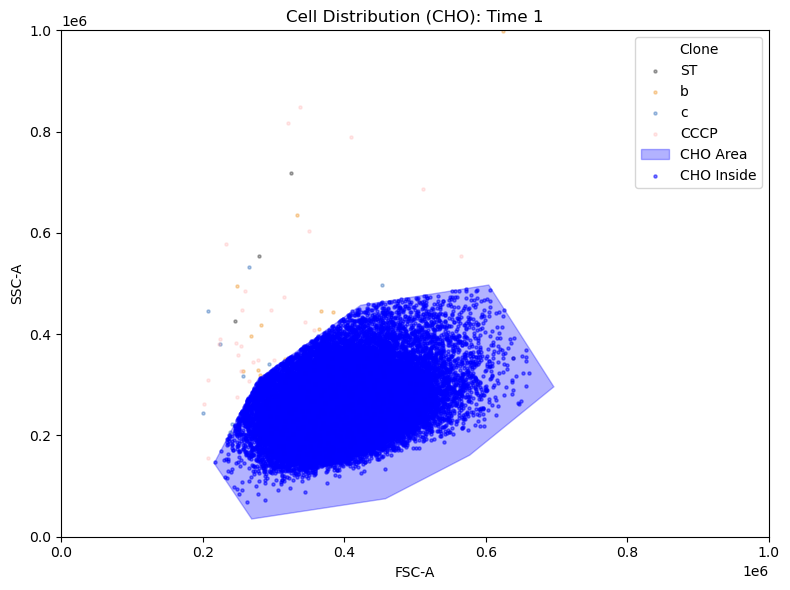

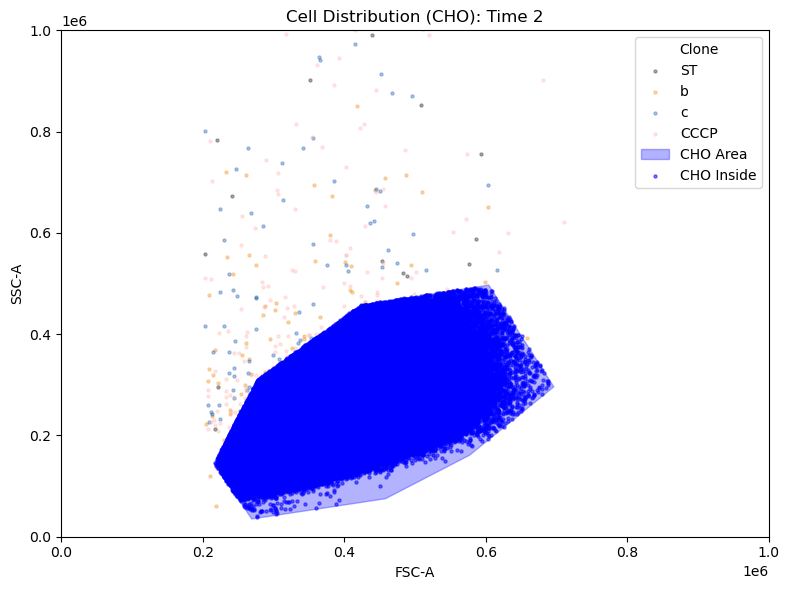

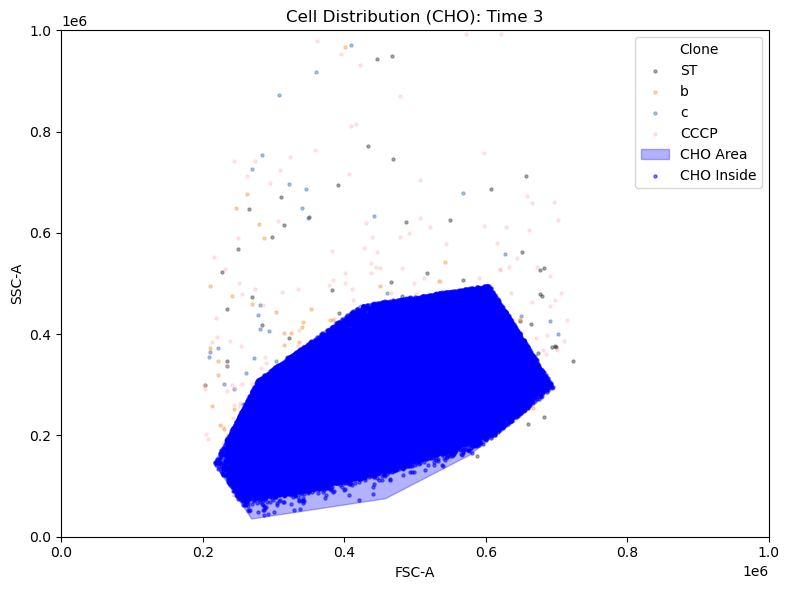

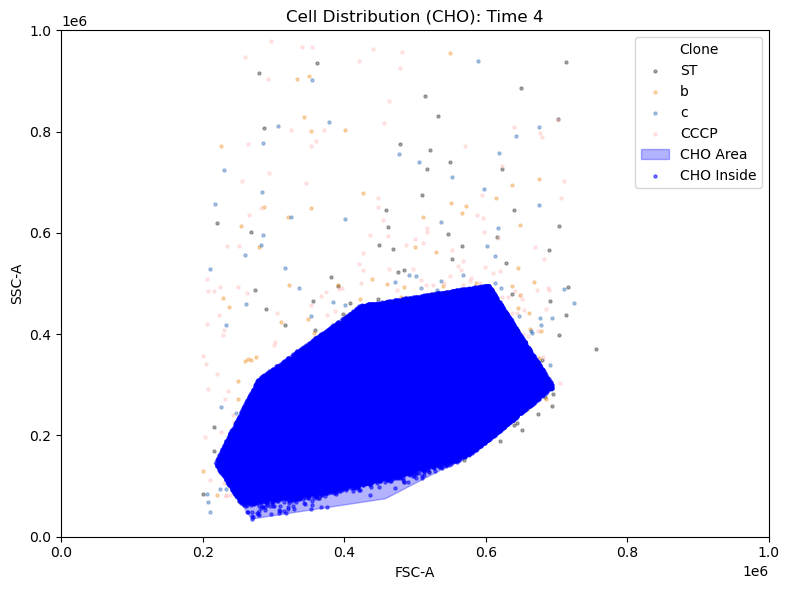

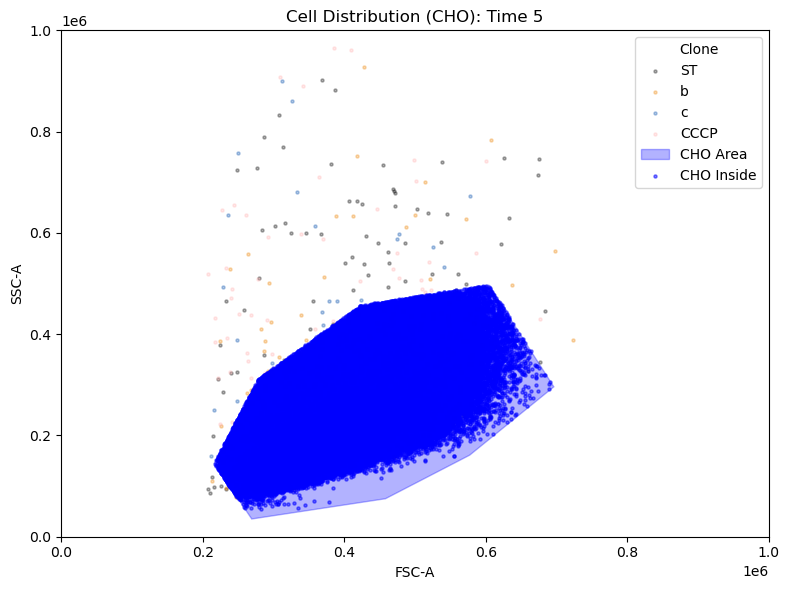

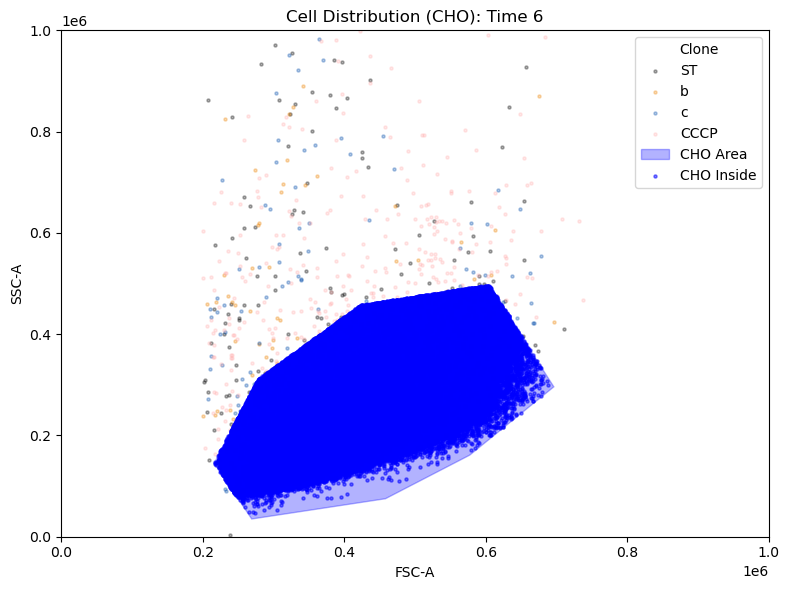

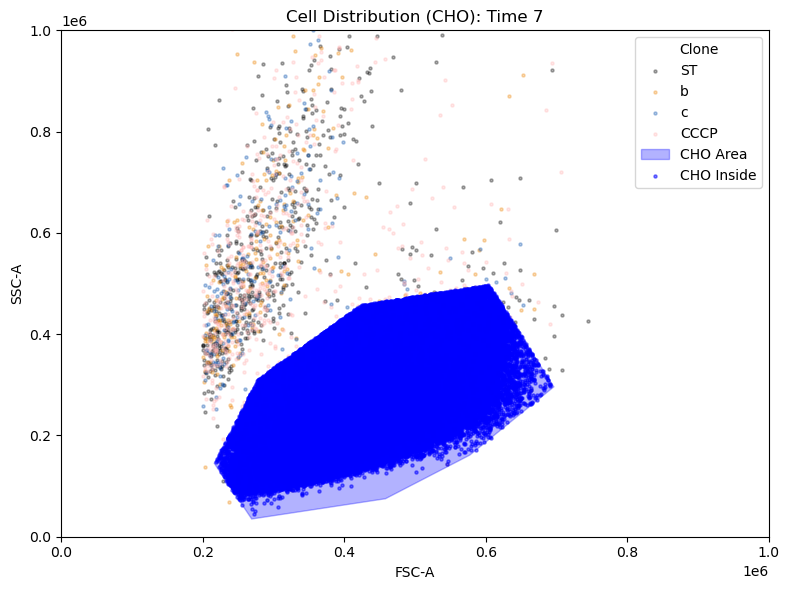

In [14]:
# Use singlets_all as singlets_df for consistency
singlets_df = singlets_all.copy()


# Start with the 'singlets_df' DataFrame, which contains data within the singlets polygon
# Define the vertices of the polygon to select the CHO cell population
cho_polygon_vertices = np.array([
    [269000, 35000], [216000, 145000], [278000, 311000],
    [423000, 457000], [604000, 497000], [696000, 296000],
    [577000, 161000], [458000, 75000]
])
cho_polygon_path = Path(cho_polygon_vertices)

# Define colors for each group
color_map = {
    'ST': '#000000',    # Black for ST
    'b': '#EC8305',     # Orange for clone b
    'c': '#024CAA',     # Blue for clone c
    'CCCP': '#FFB3B3'   # Soft red for CCCP controls
}

# 1. **Filter data within the CHO polygon**
# Create a DataFrame `CHO_df` containing only data within the CHO polygon for all time points
inside_cho_polygon = singlets_df.apply(
    lambda row: cho_polygon_path.contains_point((row['FSC-A'], row['SSC-A'])), axis=1
)
CHO_df = singlets_df.loc[inside_cho_polygon].copy()

# 2. **Subsample 1% of the data in each group for quick visualization**
# Subsample data from `singlets_df` by 'Time' and 'Clone'
data_sampled = singlets_df.groupby(['Time', 'Clone']).sample(frac=0.01, random_state=1)

# 3. **Visualize by Time with the CHO polygon**
# Get unique values of 'Time'
unique_times = data_sampled['Time'].unique()

# Create scatter plots for each time point with the CHO polygon
for time in unique_times:
    # Filter subsampled data and CHO data for the current time point
    data_time = data_sampled[data_sampled['Time'] == time]
    cho_time = CHO_df[CHO_df['Time'] == time]

    # Configure the figure for the current time point
    plt.figure(figsize=(8, 6))
    plt.title(f'Cell Distribution (CHO): Time {time}')
    plt.xlabel('FSC-A')
    plt.ylabel('SSC-A')
    plt.xlim(0, 1_000_000)
    plt.ylim(0, 1_000_000)

    # Plot each group (Clone) for the current time point
    for clone, color in color_map.items():
        data_filtered = data_time[data_time['Clone'] == clone]
        plt.scatter(data_filtered['FSC-A'], data_filtered['SSC-A'], color=color, s=5, alpha=0.3, label=clone)

    # Draw the CHO polygon
    plt.fill(*zip(*cho_polygon_vertices), color='blue', alpha=0.3, label='CHO Area')

    # Plot points inside the CHO polygon for the current time point
    plt.scatter(cho_time['FSC-A'], cho_time['SSC-A'], color='blue', s=5, alpha=0.5, label='CHO Inside')

    # Show legend and finalize the plot for the current time point
    plt.legend(title="Clone", loc='upper right')
    plt.tight_layout()
    plt.show()


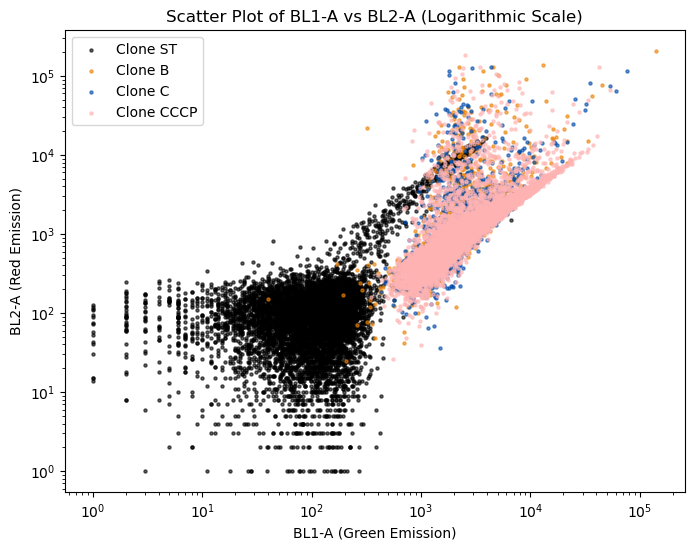

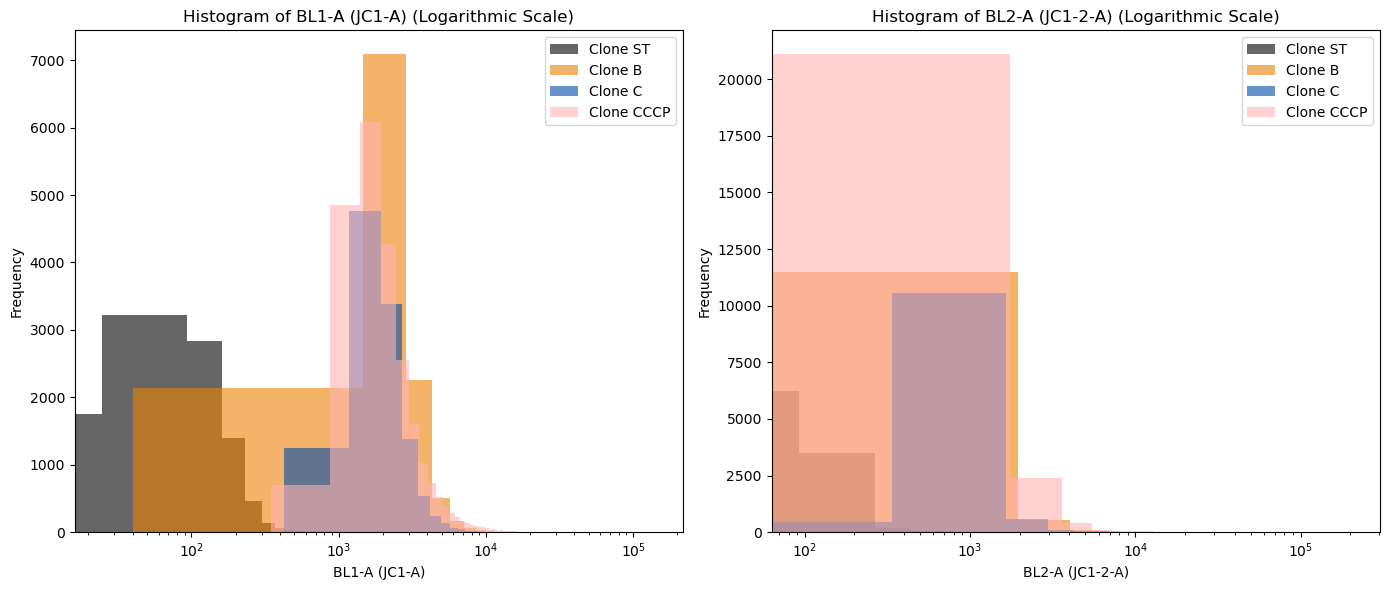

In [ ]:
# Subsample 1% of the data in `CHO_df` for visualization
cho_sampled = CHO_df.sample(frac=0.01, random_state=1)

# Define colors for each group
color_map = {
    'ST': '#000000',    # Black for ST
    'b': '#EC8305',     # Orange for clone b
    'c': '#024CAA',     # Blue for clone c
    'CCCP': '#FFB3B3'   # Soft red for CCCP controls
}

# Scatter Plot of BL1-A vs BL2-A (Logarithmic Scale)
plt.figure(figsize=(8, 6))
for clone_type, color in color_map.items():
    data_filtered = cho_sampled[cho_sampled['Clone'] == clone_type]
    plt.scatter(
        data_filtered['BL1-A'], 
        data_filtered['BL2-A'], 
        color=color, 
        s=5, 
        alpha=0.6, 
        label=f'Clone {clone_type.upper()}' if clone_type != 'control' else 'Control'
    )

# Configure logarithmic scale for both axes
plt.xscale('log')
plt.yscale('log')

# Labels and title
plt.title('Scatter Plot of BL1-A vs BL2-A (Logarithmic Scale)')
plt.xlabel('BL1-A (Green Emission)')
plt.ylabel('BL2-A (Red Emission)')
plt.legend()
plt.show()

# Histograms of BL1-A and BL2-A
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Histogram of BL1-A (JC1-A) on a logarithmic scale
for clone_type, color in color_map.items():
    data_filtered = cho_sampled[cho_sampled['Clone'] == clone_type]
    ax1.hist(
        data_filtered['BL1-A'], 
        bins=100, 
        color=color, 
        alpha=0.6, 
        label=f'Clone {clone_type.upper()}' if clone_type != 'control' else 'Control'
    )
ax1.set_xscale('log')
ax1.set_title('Histogram of BL1-A (JC1-A) (Logarithmic Scale)')
ax1.set_xlabel('BL1-A (JC1-A)')
ax1.set_ylabel('Frequency')
ax1.legend()

# Histogram of BL2-A (JC1-2-A) on a logarithmic scale
for clone_type, color in color_map.items():
    data_filtered = cho_sampled[cho_sampled['Clone'] == clone_type]
    ax2.hist(
        data_filtered['BL2-A'], 
        bins=100, 
        color=color, 
        alpha=0.6, 
        label=f'Clone {clone_type.upper()}' if clone_type != 'control' else 'Control'
    )
ax2.set_xscale('log')
ax2.set_title('Histogram of BL2-A (JC1-2-A) (Logarithmic Scale)')
ax2.set_xlabel('BL2-A (JC1-2-A)')
ax2.set_ylabel('Frequency')
ax2.legend()

plt.tight_layout()
plt.show()


C:\Users\ebald\AppData\Local\Temp\ipykernel_4780\2594772019.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CHO_b_c_df['Ratio_Red_Green'] = CHO_b_c_df['BL2-A'] / CHO_b_c_df['BL1-A']


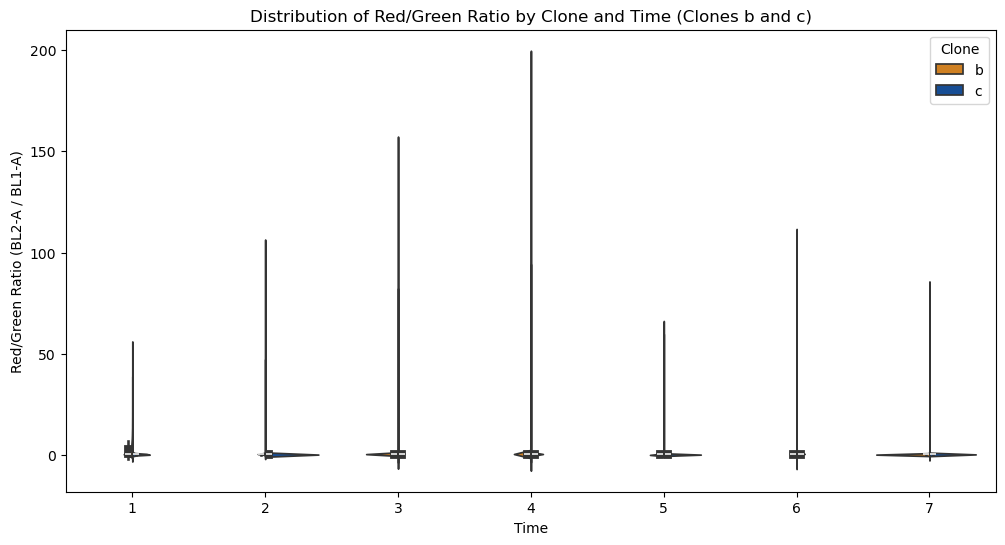

In [19]:
# Calculate the Red/Green ratio (BL2-A / BL1-A)
CHO_b_c_df['Ratio_Red_Green'] = CHO_b_c_df['BL2-A'] / CHO_b_c_df['BL1-A']

# Ensure there are no NaN or infinite values after the calculation
CHO_b_c_df = CHO_b_c_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['Ratio_Red_Green'])

# Define colors specifically for clones 'b' and 'c'
color_map_filtered = {'b': '#EC8305', 'c': '#024CAA'}  # Orange for b, Blue for c

# Violin plot to visualize the distributions of red/green ratio for clones b and c
plt.figure(figsize=(12, 6))
sns.violinplot(
    x='Time', 
    y='Ratio_Red_Green', 
    hue='Clone', 
    data=CHO_b_c_df, 
    split=True, 
    palette=color_map_filtered
)
plt.title('Distribution of Red/Green Ratio by Clone and Time (Clones b and c)')
plt.xlabel('Time')
plt.ylabel('Red/Green Ratio (BL2-A / BL1-A)')
plt.legend(title='Clone')
plt.show()

# Continue with the statistical analysis...
